In [1]:
import torch
import yaml
import os
import sys
import matplotlib.pyplot as plt

parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

from models import *
from data_module import *
from forecast_module import *
from evaluation_module import *
from helpers import *
from observation_module import *

SCRIPT_DIR = os.getcwd()
sys.path.append(os.path.dirname(SCRIPT_DIR))
print(SCRIPT_DIR)

config_path = '../../configs/ecland_emulator.yaml'

with open(config_path) as stream:
    try:
        CONFIG = yaml.safe_load(stream)
        print(f"Opening {config_path} for experiment configuration.")
    except yaml.YAMLError as exc:
        print(exc)

print(CONFIG['model_path'])
use_model = '../model'
with open(os.path.join(use_model, "hparams.yaml"), "r") as stream:
            HPARS = yaml.safe_load(stream)

print(HPARS)

cpu
/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator
/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator/notebooks
Opening ../../configs/ecland_emulator.yaml for experiment configuration.
../model/checkpoints
{'batch_size': 4, 'clim_feats': ['clim_clake', 'clim_ldepth', 'clim_ctype', 'clim_cell_area', 'clim_glm', 'clim_cu', 'clim_cvh', 'clim_cvl', 'clim_tvh', 'clim_tvl', 'clim_sotype', 'clim_geopot', 'clim_sdfor', 'clim_sdor', 'clim_theta_cap', 'clim_theta_pwp', 'clim_veg_covh', 'clim_veg_covl', 'clim_veg_z0mh', 'clim_veg_z0ml', 'clim_veg_rsminh', 'clim_veg_rsminl'], 'continue_training': False, 'db_path': '/ec/res4/hpcperm/daep/ec_land_training_db/ecland_i6aj_o400_2010_2022_6h_euro.zarr', 'device': 'cpu', 'devices': 1, 'diag_transform': 'zscoring', 'dropout': 0.1852693061424568, 'dyn_transform': 'zscoring', 'dynamic_feats': ['met_ctpf', 'met_lwdown', 'met_psurf', 'met_qair', 'met_rainf', 'met_swdown', 'met_snowf', 'met_tair',

/perm/pamw/venvs/myevalenv/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
Gevenich = ObservationModule()
Gevenich.load_station()
Gevenich.load_forcing()
closest_grid_cell = Gevenich.match_station_with_forcing()[0]

print(closest_grid_cell)
CONFIG['x_slice_indices'] = closest_grid_cell

station_data = Gevenich.process_station_data()
print(station_data.shape)

Get Euclidean Distance.
Index of closest grid cell: [np.int64(4106)]
<xarray.Dataset> Size: 3MB
Dimensions:   (x: 1, time: 18744, variable: 33)
Coordinates:
    lat       (x) float32 4B 50.93
    lon       (x) float32 4B 6.573
  * time      (time) datetime64[ns] 150kB 2010-02-01 ... 2022-11-30T18:00:00
  * variable  (variable) object 264B 'met_ctpf' 'met_lwdown' ... 'slhf' 'es'
  * x         (x) int32 4B 62986
Data variables:
    data      (time, x, variable) float32 2MB ...
4106
Converting celsius into kelvin
Resampling to 6-hourly mean.
<xarray.DataArray 'st' (time: 5, station_id: 1, depth: 3)> Size: 60B
array([[[282.9    , 282.11667, 281.21667]],

       [[282.78333, 282.15   , 281.31665]],

       [[283.15   , 282.19998, 281.41663]],

       [[282.4    , 282.31668, 281.5167 ]],

       [[282.16666, 282.18335, 281.53333]]], dtype=float32)
Coordinates:
    lon         (station_id) float32 4B 6.324
    lat         (station_id) float32 4B 50.99
    network     (station_id) <U11 44B ...

In [3]:
ForecastMLP = ForecastModule(hpars=HPARS, config=CONFIG)
dataset = ForecastMLP.initialise_dataset()
model = ForecastMLP.load_model()
X_static, X_met, Y_prog = ForecastMLP.load_test_data(dataset)

print(X_static.shape)
print(X_met.shape)
print(Y_prog.shape)

Temporal start index 17408 Temporal end index 18743
Length of dataset: 1335
Using a single grid cell
Spatial size of data set: 1
Spatial indices of data set: 4106
Use all x_idx from data set.
isint
torch.Size([23])
[11, 10, 13, 0, 14, 12, 4, 3, 6, 5, 7, 2, 9, 8, 16, 15, 20, 19, 22, 21, 18, 17]
torch.Size([22])
torch.Size([1, 1, 22])
Device:  cpu
Load model from checkpoint:  ../model/checkpoints/last.ckpt
Select one grid cell from data


/etc/ecmwf/nfs/dh1_home_a/pamw/PycharmProjects/forecast-horizons/ecland-emulator/forecast_module.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load

torch.Size([1, 1, 22])
torch.Size([1335, 1, 12])
torch.Size([1335, 1, 7])


Right now looks as if we get exactly the same values for station data and for ECLand prognostics, if we standardise. Is this a mistake? Explore non-standardised data.

In [40]:
print(CONFIG['targets_eval'])
print(dataset.targ_lst)
print(Y_prog)

matching_indices = [i for i, val in enumerate(dataset.targ_lst) if val in CONFIG['targets_eval']]
print(matching_indices)

station_data_transformed = dataset.prog_transform(station_data, means=dataset.y_prog_means[matching_indices], stds=dataset.y_prog_stdevs[matching_indices])

print(station_data_transformed)
print(station_data_transformed.shape)
station_data_transformed[:len(Y_prog)] == Y_prog[...,matching_indices]

['stl1', 'stl2', 'stl3']
['swvl1', 'swvl2', 'swvl3', 'stl1', 'stl2', 'stl3', 'snowc']
tensor([[[ 0.9074,  1.0010,  0.9762,  ..., -0.1983, -0.2411, -0.5407]],

        [[ 0.9074,  0.9910,  0.9773,  ..., -0.1966, -0.2359, -0.5407]],

        [[ 0.8928,  0.9815,  0.9778,  ..., -0.1940, -0.2306, -0.5407]],

        ...,

        [[ 0.8475,  0.8496,  0.3454,  ..., -0.2120, -0.1695, -0.5407]],

        [[ 0.8527,  0.8407,  0.3499,  ..., -0.2171, -0.1660, -0.5407]],

        [[ 0.8337,  0.8323,  0.3541,  ..., -0.2197, -0.1660, -0.5407]]])
[3, 4, 5]
tensor([[[-0.1556, -0.1983, -0.2411]],

        [[-0.1614, -0.1966, -0.2359]],

        [[-0.1431, -0.1940, -0.2306]],

        ...,

        [[    nan,     nan,     nan]],

        [[    nan,     nan,     nan]],

        [[    nan,     nan,     nan]]])
torch.Size([1460, 1, 3])


tensor([[[True, True, True]],

        [[True, True, True]],

        [[True, True, True]],

        ...,

        [[True, True, True]],

        [[True, True, True]],

        [[True, True, True]]])

In [35]:
Y_prog_hybrid = Y_prog
Y_prog_hybrid[...,matching_indices] = station_data_transformed[:Y_prog.shape[0]]
Y_prog_inv = dataset.prog_inv_transform(Y_prog, means=dataset.y_prog_means, stds=dataset.y_prog_stdevs)

Y_prog_hybrid == Y_prog

tensor([[[True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True]],

        ...,

        [[True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True]]])

In [31]:
#climatology_mu, climatology_std = ForecastMLP.get_climatology(CONFIG['climatology_path'],
#                                                     targ_lst = CONFIG['targets_prog'])
dynamic_features, dynamic_features_prediction = ForecastMLP.step_forecast(X_static, X_met, Y_prog_hybrid)

Setting model to evaluation mode
on step 0...
on step 1000...
--- 0.1967766284942627 seconds ---
--- 0.003279610474904378 minutes ---
torch.Size([1335, 1, 7])
torch.Size([1335, 1, 7])
Backtransforming


<function matplotlib.pyplot.show(close=None, block=None)>

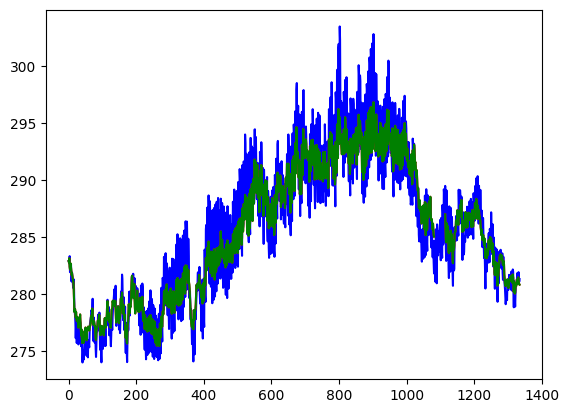

In [33]:
#climatology_mu.shape
#climatology = climatology_mu[:len(dynamic_features), :, 0]

#plt.plot(climatology, color = "black")
plt.plot(dynamic_features_prediction[:,:,3], color = "blue", label = "ailand")
plt.plot(dynamic_features[:,:,3], color = "red", label = "observations")
plt.plot(Y_prog_inv[:,:,3], color = "green", label = "ecland")
plt.show

In [30]:
sum(dynamic_features[:,:,3] == Y_prog_inv[:,:,3])

tensor([1303])

In [10]:

climatology = climatology_mu[:len(dynamic_features)]
spatial_fields = dynamic_features.shape[1]
observed_anomaly_spatial_mean = np.mean(anomaly(dynamic_features[...,0], climatology[...,0]), axis = 1)
predicted_anomaly_spatial_mean = np.mean(anomaly(dynamic_features_prediction[...,0], climatology[...,0]), axis = 1)
observed_anomaly_spatial_std = np.std(anomaly(dynamic_features[...,0], climatology[...,0]), axis = 1)
predicted_anomaly_spatial_std = np.std(anomaly(dynamic_features_prediction[...,0], climatology[...,0]), axis = 1)
print(observed_anomaly_spatial_mean.shape)
print(predicted_anomaly_spatial_mean.shape)
print(observed_anomaly_spatial_std.shape)
print(predicted_anomaly_spatial_std.shape)

numerator = np.array([(dynamic_features_prediction[:,i,0] - predicted_anomaly_spatial_mean) * (dynamic_features[:,i,0] - observed_anomaly_spatial_mean) for i in range(spatial_fields)]).sum(axis=0)
print(np.array(numerator).shape)
denominator = spatial_fields * observed_anomaly_spatial_std * predicted_anomaly_spatial_std
print(np.array(numerator).shape)
ACC = numerator / denominator
print(ACC.shape)

(1459,)
(1459,)
(1459,)
(1459,)
(1459,)
(1459,)
(1459,)


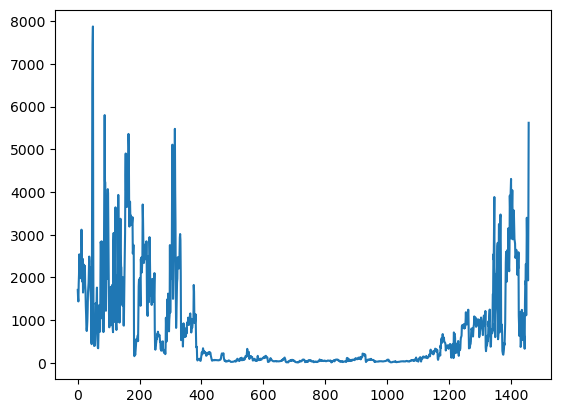

In [11]:
plt.plot(ACC)

In [33]:
mse_obs = np.sqrt(np.sum((dynamic_features_prediction - dynamic_features)**2, axis = 1))*(1/spatial_fields)
mse_clim = np.sqrt(np.sum((climatology - dynamic_features)**2, axis = 1))*(1/spatial_fields)
msess = 1 - (mse_obs[...,0]/mse_clim[...,0])

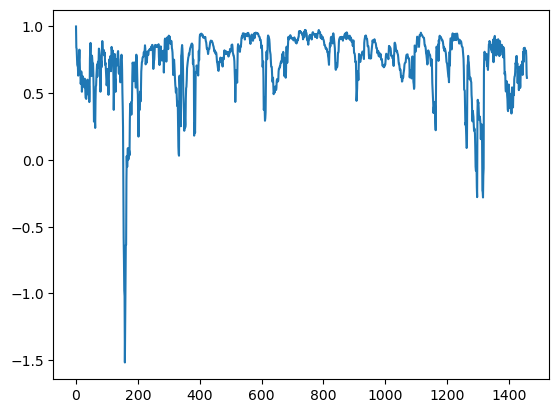

In [35]:
plt.plot(msess)

In [5]:
EvaluateMLP = EvaluationModule(ForecastMLP,
                               lead_time = len(dynamic_features), 
                               score = 'acc')
EvaluateMLP.set_test_data(dataset)
EvaluateMLP.set_climatology('analyses/climatology_6hrly_southern_england.nc')
EvaluateMLP.set_target('swvl1')
eval_out = EvaluateMLP.evaluate_target(dynamic_features, dynamic_features_prediction)

Model type is: <class 'models.MLPregressor'>
Evaluation with acc


In [43]:
mse_obs = np.sqrt(np.sum((dynamic_features_prediction - dynamic_features)**2, axis = 1))*(1/spatial_fields)
mse_clim = np.sqrt(np.sum((climatology - dynamic_features)**2, axis = 1))*(1/spatial_fields)

mse_obs = np.sum(np.abs(dynamic_features_prediction - dynamic_features), axis = 1)*(1/spatial_fields)
mse_clim = np.sum(np.abs(climatology - dynamic_features), axis = 1)*(1/spatial_fields)


msess_L1 = 1 - (mse_obs[...,0]/mse_clim[...,0])
msess_L2 = 1 - (mse_obs[...,1]/mse_clim[...,1])
msess_L3 = 1 - (mse_obs[...,2]/mse_clim[...,2])

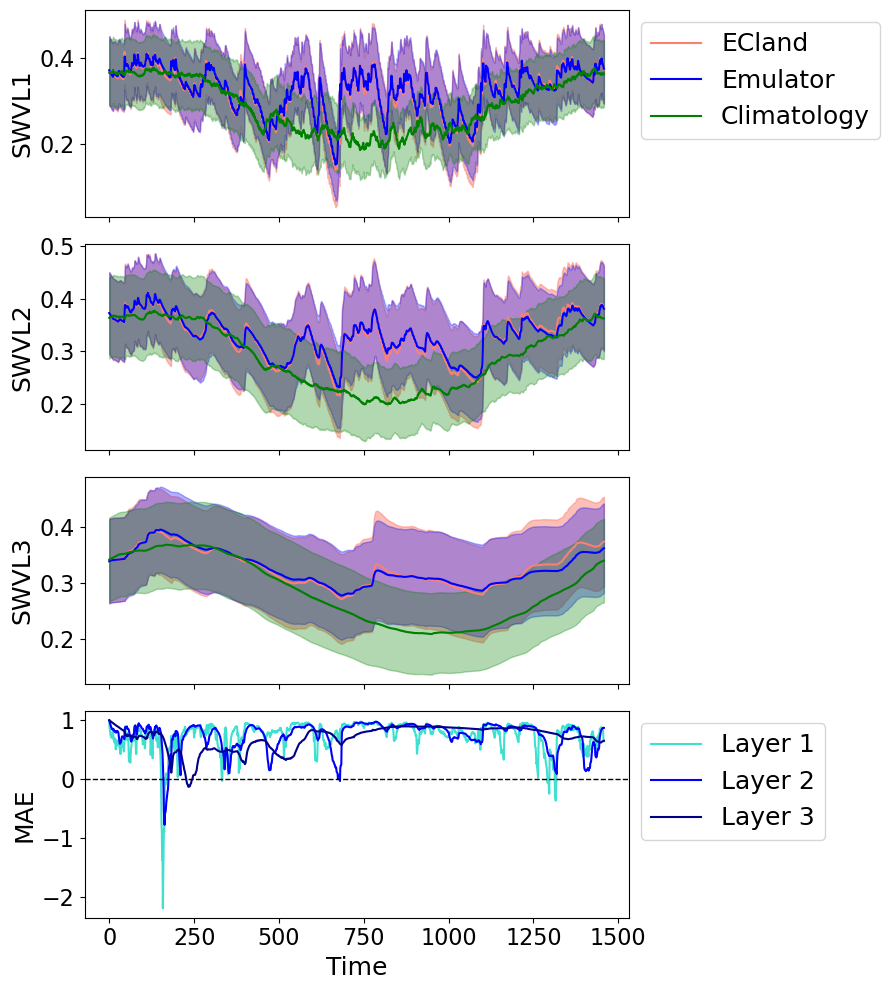

In [55]:
# Calculate mean and standard deviations
L1mean1 = np.mean(dynamic_features[...,0], axis=1)
L1std1 = dynamic_features[...,0].std(axis=1)

L1mean2 = np.mean(dynamic_features_prediction[...,0], axis=1)
L1std2 = dynamic_features_prediction[...,0].std(axis=1)

L1mean3 = np.mean(climatology_mu[:len(dynamic_features),:,0], axis=1)
L1std3 = climatology_mu[:len(dynamic_features),:,0].std(axis=1)

L2mean1 = np.mean(dynamic_features[...,1], axis=1)
L2std1 = dynamic_features[...,1].std(axis=1)

L2mean2 = np.mean(dynamic_features_prediction[...,1], axis=1)
L2std2 = dynamic_features_prediction[...,1].std(axis=1)

L2mean3 = np.mean(climatology_mu[:len(dynamic_features),:,1], axis=1)
L2std3 = climatology_mu[:len(dynamic_features),:,1].std(axis=1)

L3mean1 = np.mean(dynamic_features[...,2], axis=1)
L3std1 = dynamic_features[...,2].std(axis=1)

L3mean2 = np.mean(dynamic_features_prediction[...,2], axis=1)
L3std2 = dynamic_features_prediction[...,2].std(axis=1)

L3mean3 = np.mean(climatology_mu[:len(dynamic_features),:,2], axis=1)
L3std3 = climatology_mu[:len(dynamic_features),:,2].std(axis=1)

# Assuming L1mean1, L1std1, L1mean2, L1std2, etc. are defined
x = np.arange(1459)  # Example x-axis values for the tensors

# Create the plot with four subplots (4 rows, 1 column)
fig, axs = plt.subplots(4, 1, figsize=(9,10), sharex=True)

# Plot for Layer 1
axs[0].fill_between(x, L1mean1 - L1std1, L1mean1 + L1std1, color='salmon', alpha=0.5)
axs[0].plot(x, L1mean1, label='ECland', color='salmon')
axs[0].fill_between(x, L1mean2 - L1std2, L1mean2 + L1std2, color='blue', alpha=0.3)
axs[0].plot(x, L1mean2, label='Emulator', color='blue')
axs[0].fill_between(x, L1mean3 - L1std3, L1mean3 + L1std3, color='green', alpha=0.3)
axs[0].plot(x, L1mean3, label='Climatology', color='green')
axs[0].set_ylabel('SWVL1', fontsize=18)
axs[0].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))


# Plot for Layer 2
axs[1].fill_between(x, L2mean1 - L2std1, L2mean1 + L2std1, color='salmon', alpha=0.5)
axs[1].plot(x, L2mean1, label='ECland', color='salmon')
axs[1].fill_between(x, L2mean2 - L2std2, L2mean2 + L2std2, color='blue', alpha=0.3)
axs[1].plot(x, L2mean2, label='Emulator', color='blue')
axs[1].fill_between(x, L2mean3 - L2std3, L2mean3 + L2std3, color='green', alpha=0.3)
axs[1].plot(x, L2mean3, label='Climatology', color='green')
axs[1].set_ylabel('SWVL2', fontsize=18)
axs[1].legend().remove()

# Plot for Layer 3
axs[2].fill_between(x, L3mean1 - L3std1, L3mean1 + L3std1, color='salmon', alpha=0.5)
axs[2].plot(x, L3mean1, label='ECland', color='salmon')
axs[2].fill_between(x, L3mean2 - L3std2, L3mean2 + L3std2, color='blue', alpha=0.3)
axs[2].plot(x, L3mean2, label='Emulator', color='blue')
axs[2].fill_between(x, L3mean3 - L3std3, L3mean3 + L3std3, color='green', alpha=0.3)
axs[2].plot(x, L3mean3, label='Climatology', color='green')
axs[2].set_ylabel('SWVL3', fontsize=18)
axs[2].legend().remove()

# Plot for MAE in Layer 1, 2, 3
axs[3].plot(msess_L1, label='Layer 1', color='turquoise')
axs[3].plot(msess_L2, label='Layer 2', color='blue')
axs[3].plot(msess_L3, label='Layer 3', color='darkblue')
axs[3].axhline(0, color='black', linestyle='--', linewidth=1)  # Add the horizontal line at y=0
axs[3].set_xlabel('Time', fontsize=18)
axs[3].set_ylabel('MAE', fontsize=18)
axs[3].legend(fontsize=18, loc='upper left', bbox_to_anchor=(1, 1))

axs[0].tick_params(axis='both', labelsize=16)
axs[1].tick_params(axis='both', labelsize=16)
axs[2].tick_params(axis='both', labelsize=16)
axs[3].tick_params(axis='both', labelsize=16)

# Adjust layout to remove vertical space between subplots
plt.subplots_adjust(hspace=0.1)  # Adjust the height space between plots

# Display the plot
plt.tight_layout()
plt.savefig("plots/ailand_horizons.pdf")
plt.show()
